# Illustration

In [49]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import json
import time 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cairosvg
import io
import uuid


import open3d as o3d
from interessant import * # Bei Änderungen Kernel neu starten

ogr.UseExceptions()

In [93]:
tmpdir = "/media/riannek/minimax/gleis/temp_fertig"

# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A: 6; 
# Viele Gleise: 33; Anfang Weiche: 34; OLA gleiche H: 35; Y: 37; Auch viele Gleise: 43; Kreuzung: 44, 45; Weiche abseits 46

key = list(interessant.keys())[0] 

filename = interessant[key]
filename = filename.split(".")[0] + ".ply"
print(key, filename)


if not os.path.exists(os.path.join(tmpdir, filename)):
    raise FileNotFoundError(filename)

Einfach 4473900_5335875.ply


In [51]:
thresh_side_distance = 0.15   # 0.1 ist meist gut, aber in manchen Fällen zu wenig (z.B. Anfang Weiche)

intensity_threshold = 14500
downsample_radius = 0.45 # 0.4
neighborhood_radius = 0.5 # 0.5

min_points = 10
minimum_in_hood = 10
linearity_tresh = 0.98

gauge = 1.435
railhead_width = 0.067

In [ ]:
runfolder = "/media/riannek/minimax/gleis/run24-2024-08-13"

import subprocess
subprocess.Popen(["pyvistaviewer", os.path.join(runfolder, filename.split(".")[0] + ".copc.laz")])

<Popen: returncode: None args: ['pyvistaviewer', '/media/riannek/minimax/gle...>

Reading /media/riannek/minimax/gleis/run24-2024-08-13/4473900_5335875.copc.laz
Press "M" to toggle between Intensity, RGB, and Classification modes
Press "Left" and "Right" arrow keys to rotate the point cloud around Z-axis


## Datei incl. margin aus Nachbarkacheln

In [53]:
gpkg = ogr.Open(os.path.join(tmpdir, "temp.gpkg"))
layer = gpkg.GetLayerByName("tiles")

In [54]:
def extend_bbox(bbox, margin=2):
    # MinX, MaxX, MinY, MaxY
    return (bbox[0] - margin, bbox[1] + margin, bbox[2] - margin, bbox[3] + margin)

def get_bbox_polygon(bbox):  
    ring = ogr.Geometry(ogr.wkbLinearRing)      
    ring.AddPoint_2D(bbox[0], bbox[2])  # MinX, MinY
    ring.AddPoint_2D(bbox[1], bbox[2])  # MaxX, MinY
    ring.AddPoint_2D(bbox[1], bbox[3])  # MaxX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[3])  # MinX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[2])  # Close ring
    geom = ogr.Geometry(ogr.wkbPolygon)
    geom.AddGeometry(ring)
    return geom

In [55]:
filter = f"filename = '{filename}'"
layer.SetAttributeFilter(filter)
feature = layer.GetNextFeature()
layer.SetAttributeFilter(None)
bbox = feature.GetGeometryRef().GetEnvelope()
extended = extend_bbox(bbox, margin=2)
bbox_geom = get_bbox_polygon(extended)
layer.SetSpatialFilter(bbox_geom)
tiles = [f.GetField("filename") for f in layer]
layer.SetSpatialFilter(None) 

print(tiles) 

['4473650_5337950.ply', '4473650_5337975.ply', '4473625_5337975.ply', '4473625_5338000.ply', '4473650_5338000.ply', '4473625_5337950.ply']


In [56]:
bbox # MinX, MaxX, MinY, MaxY

(4473633.296, 4473650.0, 5337975.0, 5338000.0)

In [57]:
del gpkg

In [58]:
bounds = f"([{extended[0]}, {extended[1]}], [{extended[2]}, {extended[3]}])" 
bounds

'([4473631.296, 4473652.0], [5337973.0, 5338002.0])'

In [59]:
readers = [pdal.Reader(os.path.join(tmpdir, tile)) for tile in tiles]
pipeline = pdal.Pipeline(readers) | pdal.Filter.merge() | pdal.Filter.crop(bounds=bounds)
pipeline.execute()
points = pipeline.arrays[0]
points.shape 

(6332,)

## Seed Points

In [60]:
low_intensity = points[points["Intensity"] < intensity_threshold]
low_intensity.shape

(5180,)

In [61]:
bounds = f"([{bbox[0]}, {bbox[1]}], [{bbox[2]}, {bbox[3]}])" 
bounds

'([4473633.296, 4473650.0], [5337975.0, 5338000.0])'

In [62]:
# Downsample with poisson sampling (only original bbox)

downsampling_pipeline = pdal.Filter.crop(bounds=bounds).pipeline(low_intensity) | pdal.Filter("filters.sample", radius=downsample_radius)
downsampling_pipeline.execute()
seed_points = downsampling_pipeline.arrays[0]
seed_point_count = seed_points.shape[0]
seed_point_count

178

## KD Tree

In [63]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
xyz_seed = np.vstack((seed_points['X'], seed_points['Y'], seed_points['Z'])).transpose()

In [64]:
offset = xyz.mean(axis=0).round() 
xyz -= offset
xyz_seed -= offset

In [65]:
tree = KDTree(xyz)  

# indices: ndarray (dtype object) with a list of indices for each seed point
indices = tree.query_ball_point(xyz_seed, r=neighborhood_radius, workers=-1)

## Funktionen

In [66]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T

def linearity(eigenvals):
    """Calculate the linearity of a point cloud"""
    return (eigenvals[0] - eigenvals[1]) / eigenvals[0]

In [67]:
def dbscan_stretchz(xyz, min_points=10, stretch=1.5):

    pointcount = xyz.shape[0]
    if pointcount <= min_points:
        return np.ones(pointcount, dtype=np.int8) * -1
    
    eps = 50 / pointcount
    eps = max(eps, 0.06)
    
    xyz = xyz.copy()
    xyz[:, 2] *= stretch
    hood_pcd = o3d.geometry.PointCloud()
    hood_pcd.points = o3d.utility.Vector3dVector(xyz) 
    # eps is min distance between clusters
    labels = np.array(hood_pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=False))
    return labels



In [68]:
def get_central_point(a, b):
    """Get the point in the middle of two points"""
    vector = b - a
    return a + vector / 2

In [69]:
def to_color(skalar, cmap=plt.cm.plasma):
    return cmap(skalar)[:3]

In [70]:
def cluster_is_on_top(cluster, clustercenter, points):
    """Check that there are no points above the cluster center"""
    x_min, x_max = clustercenter[0] - 0.05, clustercenter[0] + 0.05
    y_min, y_max = clustercenter[1] - 0.05, clustercenter[1] + 0.05
    z_min = cluster[:,2].max()

    mask = ((points[:, 0] > x_min) & 
        (points[:, 0] < x_max) & 
        (points[:, 1] > y_min) & 
        (points[:, 1] < y_max) & 
        (points[:, 2] > z_min))
    
    
    return points[mask].shape[0] == 0


In [71]:
def cluster_generator(points, min_points):
    if points.shape[0] < min_points:
        return
    
    labels = dbscan_stretchz(points, min_points=min_points, stretch=4)
    max_label = labels.max()
    
    for label in range(max_label + 1):
        cluster = points[labels == label]
        if cluster.shape[0] < min_points:
            # Somehow this happens, must be a bug in open3d
            continue

        eigenvals, eigenvects = pca(cluster)
        cluster_linearity = linearity(eigenvals)


        if not ((cluster_linearity > linearity_tresh) and (eigenvals[0] > 0.04)):
            # Cluster not linear or too short
            continue

        clustercenter = cluster.mean(axis=0)

        # Make sure there are no points above the cluster
        # (exclude clusters at the base of the track profile)
        if not cluster_is_on_top(cluster, clustercenter, points):
            continue
        

        yield cluster, clustercenter, eigenvals, eigenvects


def check_cluster_for_railpair(clustercenter, eigenvects, pointcloud, tree, gauge, min_points):

    # Check for rail pair
    sidevector = np.cross(eigenvects[:,0], np.array([0, 0, 1])) * (gauge + 0.07) # Add railtop width to gauge
    bothsides = np.array([clustercenter + sidevector, clustercenter - sidevector])

    indices_bothsides = tree.query_ball_point(bothsides, r=neighborhood_radius)
    
    # Linear cluster that is closest to one of the estimated side points (ignoring z)
    # but must me within r = 15 cm and almost parallel

    closest_cluster_distance = np.inf
    closest_cluster = None
    closest_cluster_center = None
    
    for j, side in enumerate(indices_bothsides):
        for sidecluster, sideclustercenter, _, eigenvects_side in cluster_generator(pointcloud[side], min_points):
            
            # Check distance
            sidecluster_distance = np.linalg.norm(sideclustercenter[:2] - bothsides[j][:2]) # only xy
            if sidecluster_distance < thresh_side_distance and sidecluster_distance < closest_cluster_distance:
                # Check if parallel
                cos_angle = np.abs(np.dot(eigenvects[:,0], eigenvects_side[:,0]))
                if cos_angle > 0.9:  
                    closest_cluster = sidecluster
                    closest_cluster_distance = sidecluster_distance
                    closest_cluster_center = sideclustercenter

    return closest_cluster, closest_cluster_center

In [72]:
def which_side(cluster):
    """Check which on which side of the rail the transformed cluster is
    
    Returns a value between -1 and 1, positive values if points are on the 
    right side of the rail, and negative values for the left side. 
    The absolute value is kind of the confidence of the estimation.
    """

    # Count the points below the centroid, on the left and the right side 
    # but only within half the width of the railhead 

    left_mask = (cluster[:,2] < 0) & (cluster[:,0] < 0) & (cluster[:,0] > -railhead_width/2)
    right_mask = (cluster[:,2] < 0) & (cluster[:,0] > 0) & (cluster[:,0] < railhead_width/2)
    left_count = np.sum(left_mask)
    right_count = np.sum(right_mask)
    both_count = left_count + right_count
    if both_count == 0:
        return 0
    return (left_count - right_count) / both_count

In [73]:
def representive_point_3(cluster, transformmatrix, upperpercentile=90, lowerpercentile=70, railhead_width=0.067, side=None):
    """Version 3

    Unterschied bei "Vor allem Top": 
        min und max x bei z>-0.01
        lowerpercentile des oberen Teils für z
    """


    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = transformed[:,2].max()

    if max_z < 0.03:
        # This happens if most points are on the top of the rail (usually max_z close to 0.02)
        # Calculate the mean of the range for points above -0.01
        # (this makes sure we get the approx. railhead width)
        transformed_x_upper = transformed[transformed[:,2] > -0.01][:,0]
        center_x = (transformed_x_upper.max() + transformed_x_upper.min()) / 2
        # only consider points above the centroid
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], lowerpercentile)
        side = 0
    else:
        # Many points are on the side of the rail (usually the max_z around 0.04)
        # but we need check which side 

        if side is None:
            side = which_side(transformed)

        # x values of points above the centroid
        # (there might be outliers in the lower part of the cluster)
        transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

        if side < 0:
            # left side
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            center_x = min_x + railhead_width / 2
        else:
            max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            center_x = max_x - railhead_width / 2 
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], upperpercentile)

    
    transformed_representive = np.array([center_x, 0, center_z])
    return transformed_representive @ transformmatrix.T + center, side

In [74]:
# Convert SVG to PNG in memory
svg_file = "Schiene.svg"
png_bytes = cairosvg.svg2png(url=svg_file, dpi=300)
png_image = mpimg.imread(io.BytesIO(png_bytes), format='png')

In [75]:
def pair_generator():

    for i in range(seed_point_count):
        for cluster, clustercenter, eigenvals, eigenvects in cluster_generator(xyz[indices[i]], min_points=min_points):
            cluster_other, center_other = check_cluster_for_railpair(clustercenter, eigenvects, xyz, tree, gauge, min_points)
            if cluster_other is not None:
                yield cluster, clustercenter, cluster_other, center_other, eigenvects 

In [76]:
def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects):
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(eigenvects.T[0], sidevector_perpendicular) 

    if normal[2] < 0:
        # print("Switched normal")
        normal *= -1

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    return matrix

Reading /media/riannek/minimax/gleis/run24-2024-08-13/4473625_5337975.copc.laz


In [77]:
def plot_cluster_pair(cluster, cluster_other, transformmatrix, representive_a, representive_b, railhead_width = 0.067, annotate=True, lines=False, figsize=(10, 5)): 
    """Plot pair of clusters in the PCA coordinate system of the pair 
    
    Args:
        cluster (np.array): Cluster of points
        cluster_other (np.array): Other cluster of points
        transformmatrix (np.array): Transformation matrix to local coordinate system
        representive_a (np.array): Representive point of cluster a
        representive_b (np.array): Representive point of cluster b
        railhead_width (float): Width of the railhead (0.067 or 0.072)
        centering (str): "cluster" or "pair"
        annotate (bool): If True, add annotations to the plot
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)


    cluster = cluster - center_cluster
    cluster_other = cluster_other - center_other


    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    
    representive_a = representive_a - center_cluster
    representive_b = representive_b - center_other
    representive_a = representive_a @ transformmatrix
    representive_b = representive_b @ transformmatrix


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        representive_a, representive_b = representive_b, representive_a
        print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=figsize)

    ax[0].set_ylim(-0.16, 0.08)
    ax[1].set_ylim(-0.16, 0.08)


    svgscale = 0.0895
    svg_yoffset = 0.012
    svg_xoffset = -0.0008
   
    ax[0].imshow(png_image, extent=[representive_a[0] - svgscale + svg_xoffset, representive_a[0] + svgscale + svg_xoffset, representive_a[2] + svg_yoffset - (2*svgscale), representive_a[2] + svg_yoffset], aspect='auto', zorder=-2)
    ax[1].imshow(png_image, extent=[representive_b[0] - svgscale + svg_xoffset, representive_b[0] + svgscale + svg_xoffset, representive_b[2] + svg_yoffset - (2*svgscale), representive_b[2] + svg_yoffset], aspect='auto', zorder=-2)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")
    ax[1].set_aspect("equal")

    ax[0].set_axis_off()
    ax[1].set_axis_off()

    if lines:

        # ax[0].axvline(representive_a[0] - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
        # ax[0].axvline(representive_a[0] + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
        # ax[1].axvline(representive_b[0] - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
        # ax[1].axvline(representive_b[0] + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)

        ax[0].axvline(representive_a[0], color="forestgreen", linestyle="--", zorder=-1)
        ax[0].axhline(representive_a[2], color="forestgreen", linestyle="--", zorder=-1)
        ax[1].axvline(representive_b[0], color="forestgreen", linestyle="--", zorder=-1)
        ax[1].axhline(representive_b[2], color="forestgreen", linestyle="--", zorder=-1)

        # ax[0].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
        # ax[0].axhline(0, color="lightgrey", linestyle="-", zorder=-1)
        # ax[1].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
        # ax[1].axhline(0, color="lightgrey", linestyle="-", zorder=-1)

    if annotate:
        zcenters = (representive_a[2], representive_b[2])
        xcenters = (representive_a[0], representive_b[0])
        for i in range(2):
            ax[i].annotate('Clustercentroid', xy=(0, 0), xytext=(0.001, -0.02), 
                arrowprops=dict(arrowstyle="->"), ha="left", va="center", fontsize=9, color="black")
            ypos = zcenters[i]
            ax[i].annotate('gewählter Punkt', xy=(xcenters[i], ypos), xytext=(xcenters[i] + 0.001, ypos + 0.01),
                arrowprops=dict(arrowstyle="->"), ha="left", va="center", fontsize=9, color="black")

            ypos = -0.077 
            half_head = railhead_width / 2
            ax[i].annotate('67 mm', xy=(xcenters[i]+half_head, ypos), xytext=(xcenters[i], ypos),
                arrowprops=dict(arrowstyle="->"), ha="center", va="center", fontsize=9, color="white")
            ax[i].annotate('67 mm', xy=(xcenters[i]-half_head, ypos), xytext=(xcenters[i], ypos),
                arrowprops=dict(arrowstyle="->"), ha="center", va="center", fontsize=9, color="black")

    plt.show()
    return fig, ax, transformed, transformed_other



## Einzeln

In [78]:
pair_gen = pair_generator()

In [79]:
# for i in range(122):
#     next(pair_gen)

Sides 0.9310344827586207 0.9310344827586207
Points per Cluster 58 54
Switched clusters


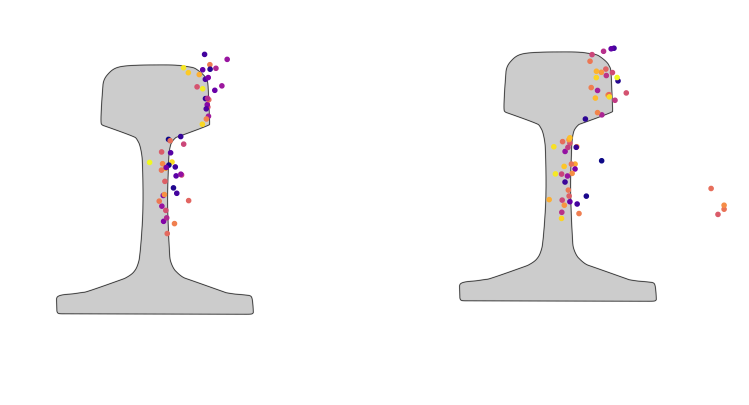

In [92]:
cluster, clustercenter, cluster_other, clustercenter_other, eigenvects = next(pair_gen)

percentile = 95

upperpercentile=90
lowerpercentile = 70

transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects)
#print("Transformmatrix")
#print(transformmatrix)

if transformmatrix[2,2] < 0: # z of the third eigenvector
    print("Inverted eigenvectors")
    transformmatrix *= -1
    

representative_a, side_a  = representive_point_3(cluster, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)
representative_b, side_b = representive_point_3(cluster_other, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)

print("Sides", side_a, side_b)

# Check if both are classified as the same side
# but a zero and non zero value is not a problem
if side_a * side_b < 0:
    print("Different sides")
    # Update the cluster with lower confidence of the side estimation
    if np.abs(side_a) < np.abs(side_b):
        representative_a, side_a  = representive_point_3(cluster, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_b)
    else:
        representative_b, side_b = representive_point_3(cluster_other, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_a)


    #representative_aaa, representative_bbb = representative_bbb, representative_aaa

# print("Central Point", central)
# print("Representive Points:", representive_a, representive_b)

#o3d.visualization.draw_geometries([pcd_all, pcd_clusters, mesh_frame, pcd_clustercenters, pcd_representive])
print("Points per Cluster", len(cluster), len(cluster_other))
fig, ax, transformed, transformed_other = plot_cluster_pair(cluster, cluster_other, transformmatrix, representative_a, representative_b, railhead_width = 0.067, annotate=False, lines=False)

# Grün: Version 0; Blau: Version 1; Braun: Version 2

In [81]:
raise ValueError("Stop here")

ValueError: Stop here

In [90]:
# Save the figure

folder = "schienenillustration_nolines"
filename = f"{key}_{uuid.uuid4()}.png"
print(filename)
if not os.path.exists(folder):
    os.makedirs(folder)
fig.savefig(os.path.join(folder, filename), dpi=300, bbox_inches='tight')

Gleis weit abseits_63f8947a-3f01-42c8-80b9-6766f7592c64.png


In [ ]:
pair = np.vstack((cluster, cluster_other))
pcd_clusters = o3d.geometry.PointCloud()
pcd_clusters.points = o3d.utility.Vector3dVector(pair)
pcd_clusters.paint_uniform_color([0, 0, 1])

pcd_clustercenters = o3d.geometry.PointCloud()
pcd_clustercenters.points = o3d.utility.Vector3dVector([clustercenter, clustercenter_other])
pcd_clustercenters.paint_uniform_color([0, 1, 0])

pcd_all = o3d.geometry.PointCloud()
pcd_all.points = o3d.utility.Vector3dVector(xyz)
pcd_all.paint_uniform_color([0.7, 0.7, 0.7])

pcd_representive = o3d.geometry.PointCloud()
pcd_representive.points = o3d.utility.Vector3dVector([representative_a, representative_b])
pcd_representive.paint_uniform_color([1, 0, 0])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd_all, pcd_clusters, mesh_frame, pcd_clustercenters, pcd_representive])

# Experimentieren